Test cases: 255
Classification accuracy: 0.9803921568627451
Time taken: 3.894542932510376


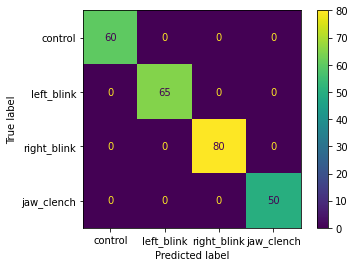

['./models/mlp2.joblib']

In [42]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import plot_confusion_matrix

from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from joblib import Parallel, delayed
from time import time

folder = "../Collected_Data/FormattedEEG/"
types = ["control", "left_blink", "right_blink", "jaw_clench"]
paths = np.array([["left_blink_var1", 1], ["left_blink_var2", 1], ["right_blink_var1", 2], ["right_blink_var2", 2], ["control_var1", 0], ["control_var2", 0], ["control_var3", 0], ["jaw_clench_var1", 3], ["jaw_clench_var2", 3]])

# Read in csv files
def read_csvs(folder, types, paths):
    output_x = []
    output_y = []
    
    for path in paths:
        i = 1
        while True:
            try:
                cur_path = folder + types[int(path[1])] + "/" + path[0] + "_" + str(i) + "_" + "formatted.csv"
                # print(cur_path)
                input_data = pd.read_csv(cur_path, header = 0, usecols=[1, 2, 3, 4])
                X = input_data.to_numpy()[150:900]
                X = X.T
                y = path[1] 
                output_x.append(X)
                output_y.append(float(y))
                i += 1
            except:
                break;
    
    output_x = np.array(output_x) 
    output_y = np.array(output_y)
    return output_x, output_y

def train_model(X, y, n_splits, model):
    cv = KFold(n_splits, shuffle=True)
    clf = make_pipeline(XdawnCovariances(estimator="oas", nfilter=2), TangentSpace(metric = "riemann"), model)
    pred = np.zeros(len(y))
    
    def train_single_set(train_idx, test_idx):
        y_train, y_test = y[train_idx], y[test_idx]
        clf.fit(X[train_idx], y_train)
        y_predict = clf.predict(X[test_idx])
        return dict(test_idx = test_idx, y_predict = y_predict)
        
    out = Parallel(n_jobs = -1)(delayed(train_single_set)(train_idx, test_idx) for train_idx, test_idx in cv.split(X))
    for d in out:
        pred[d["test_idx"]] = d["y_predict"]
    
    clf = clf.fit(X, y)
    
    return clf, pred


X, y = read_csvs(folder, types, paths)

dur = time()
clf, pred = train_model(X, y, 8, MLPClassifier(hidden_layer_sizes=(200, ), learning_rate="adaptive", max_iter=10000, solver="lbfgs"))
dur = time() - dur

acc = np.mean(pred == y)
                        
print(f"Test cases: {len(y)}")
print(f"Classification accuracy: {acc}")
print(f"Time taken: {dur}" )
plot_confusion_matrix(clf, X, y, display_labels=types)
plt.show()

dump(clf, './models/mlp2.joblib')

In [ ]:
from time import time

folder = "../Collected_Data/FormattedEEG/"
types = ["control", "left_blink", "right_blink"]
paths_orig = np.array([["left_blink_var1", 1],["left_blink_var2", 1], ["right_blink_var1", 2], ["right_blink_var2", 2], ["control_var1", 0], ["control_var2", 0]])
noleftvar1 = np.array([["left_blink_var2", 1], ["right_blink_var1", 2], ["right_blink_var2", 2], ["control_var1", 0], ["control_var2", 0]])
noleftvar2 = np.array([["left_blink_var1", 1], ["right_blink_var1", 2], ["right_blink_var2", 2], ["control_var1", 0], ["control_var2", 0]])
norightvar1 = np.array([["left_blink_var1", 1],["left_blink_var2", 1], ["right_blink_var2", 2], ["control_var1", 0], ["control_var2", 0]])
norightvar2 = np.array([["left_blink_var1", 1],["left_blink_var2", 1], ["right_blink_var1", 2], ["control_var1", 0], ["control_var2", 0]])
nocontrol1 = np.array([["left_blink_var1", 1],["left_blink_var2", 1], ["right_blink_var1", 2], ["right_blink_var2", 2], ["control_var2", 0]])
nocontrol2 = np.array([["left_blink_var1", 1],["left_blink_var2", 1], ["right_blink_var1", 2], ["right_blink_var2", 2], ["control_var1", 0]])

paths_list = [[paths_orig, "original"], [noleftvar1, "no left blink var1"], [noleftvar2, "no left blink var2"], [norightvar1, "no right var1"], [norightvar2, "no right var2"], [nocontrol1, "no control var 1"], [nocontrol2, "no control var 2"]]
for paths in paths_list:
    X, y = read_csvs(folder, types, paths[0])


    cv = KFold(n_splits=4, shuffle=True)

    clf = make_pipeline(XdawnCovariances(estimator='oas'), TangentSpace(metric = "riemann"), RandomForestClassifier(n_estimators=500, n_jobs=4))

    pred = np.zeros(len(y))
    print("Test: " + paths[1])
    print("Test size:" + str(len(y)))

    for train_idx, test_idx in cv.split(X):
        y_train, y_test = y[train_idx], y[test_idx]
        clf.fit(X[train_idx], y_train)
        pred[test_idx] = clf.predict(X[test_idx])

    count = 0
    wrong_labelled = []
    for j in range(len(pred)):
        if pred[j] == y[j]:
            count += 1
        else:
            wrong_labelled.append(j)
    print(wrong_labelled)
    acc = count / len(pred)
    print("Classification accuracy: %f \n" % (acc))
    plot_confusion_matrix(clf, X, y, display_labels=types)  
    plt.show()  

Test: original
Test size:75
Classification accuracy: 0.973333 



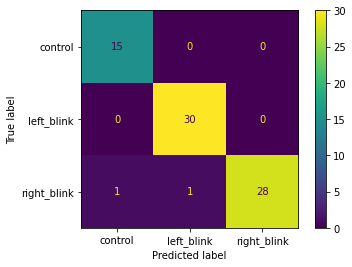

Test: no left blink var1
Test size:55
Classification accuracy: 0.963636 



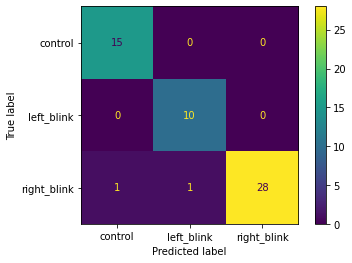

Test: no left blink var2
Test size:65
Classification accuracy: 0.969231 



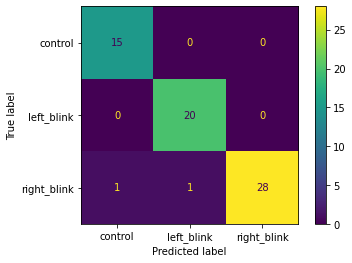

Test: no right var1
Test size:55
Classification accuracy: 0.963636 



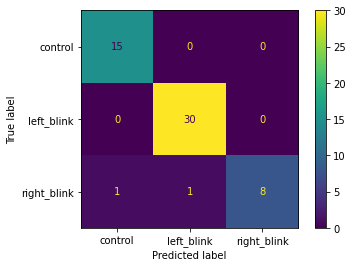

Test: no right var2
Test size:65
Classification accuracy: 1.000000 



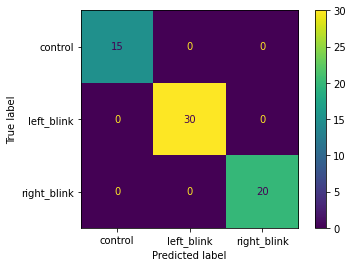

Test: no control var 1
Test size:65
Classification accuracy: 0.969231 



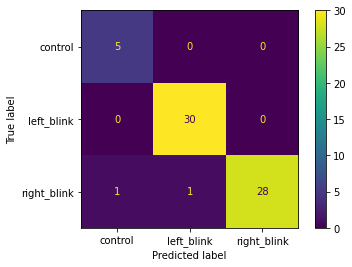

Test: no control var 2
Test size:70
Classification accuracy: 0.971429 



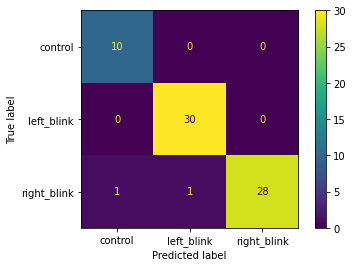

In [42]:
from time import time

folder = "../Collected_Data/FormattedEEG/"
types = ["control", "left_blink", "right_blink"]
paths_orig = np.array([["left_blink_var1", 1],["left_blink_var2", 1], ["right_blink_var1", 2], ["right_blink_var2", 2], ["control_var1", 0], ["control_var2", 0]])
noleftvar1 = np.array([["left_blink_var2", 1], ["right_blink_var1", 2], ["right_blink_var2", 2], ["control_var1", 0], ["control_var2", 0]])
noleftvar2 = np.array([["left_blink_var1", 1], ["right_blink_var1", 2], ["right_blink_var2", 2], ["control_var1", 0], ["control_var2", 0]])
norightvar1 = np.array([["left_blink_var1", 1],["left_blink_var2", 1], ["right_blink_var2", 2], ["control_var1", 0], ["control_var2", 0]])
norightvar2 = np.array([["left_blink_var1", 1],["left_blink_var2", 1], ["right_blink_var1", 2], ["control_var1", 0], ["control_var2", 0]])
nocontrol1 = np.array([["left_blink_var1", 1],["left_blink_var2", 1], ["right_blink_var1", 2], ["right_blink_var2", 2], ["control_var2", 0]])
nocontrol2 = np.array([["left_blink_var1", 1],["left_blink_var2", 1], ["right_blink_var1", 2], ["right_blink_var2", 2], ["control_var1", 0]])

paths_list = [[paths_orig, "original"], [noleftvar1, "no left blink var1"], [noleftvar2, "no left blink var2"], [norightvar1, "no right var1"], [norightvar2, "no right var2"], [nocontrol1, "no control var 1"], [nocontrol2, "no control var 2"]]
clf = load('./models/saved_model1.joblib')
for paths in paths_list:
    X, y = read_csvs(folder, types, paths[0])
    pred = clf.predict(X)
    print("Test: " + paths[1])
    print("Test size:" + str(len(y)))
    acc = np.mean(pred == y)
    print("Classification accuracy: %f \n" % (acc))
    plot_confusion_matrix(clf, X, y, display_labels=types)  
    plt.show()  